# Capstone Final Project

## Background
Data source: https://www.cde.ca.gov/ds/ad/downloadabledata.asp#SRD

**Question to answer**: What is the percentage of students from a California high school that will meet UC/CSU entrance requirements by the time they graduate?

**Expected data source**: The data that will be used is sourced from California's Department of Education (CDE) website. The following data were used to predict the percentage of students in a California high school meeting UC/CSU requirements:

1) The city the public school is in

2) Public school type (i.e., charter/magnet/year-round/virtual)
The "virtual" column has different values: 

F = Exclusively Virtual – The school has no physical building where students meet with each other or with teachers, all instruction is virtual.

V = Primarily Virtual – The school focuses on a systematic program of virtual instruction but includes some physical meetings among students or with teachers.

C = Primarily Classroom – The school offers virtual courses but virtual instruction is not the primary means of instruction.

N = Not Virtual – The school does not offer any virtual instruction.

P = Partial Virtual – The school offers some, but not all, instruction through virtual instruction. Note: This value was retired and replaced with the Primarily Virtual and Primarily Classroom values beginning with the 2016–17 school year.

3) Percent of students in the school who are eligible for free/reduced-priced meals

4) The average employment type of teachers at the school (i.e., values closer to 1 means that a majority of teachers at the school have full time teaching positions)

5) Whether the school has UC/CSU-approved classes (i.e., Values closer to 1 means a majority of the classes at the school are UC/CSU approved. Values closer to 0 means a majority of the classes at the school are NOT UC/CSU approved)

6) Whether or not the classes in a school is a core academic class under No Child Left Behind (NCLB) (i.e., Values closer to 1 means a majority of the classes at the school are core academic classes under NCLB)

7) The suspension rate of the school during the 2016-2017 school year (i.e., The unduplicated count of students suspended divided by the cumulative enrollment at the selected entity for the selected student population)

8) Chronic absenteeism rate (i.e., The unduplicated count of students determined to be chronically absent [Chronic Absenteeism Count] divided by the Chronic Absenteeism Enrollment at the selected entity for the selected population using the available filters)

9) Percentage of students in school who are English language learners (ELL)

Because these information is uploaded separately on the CDE website, the most recent year that is reported for all data categories is the 2016-2017 school year.

**Technique expected to be used in your analysis**: Linear regression would be the most appropriate technique to use in this machine learning problem rather than classification techniques such as logistic regression, KNN, decision trees, and support vector machines.

## 1) Import Libraries

In [56]:
import plotly.express as px
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')
import category_encoders as ce

## 2) Organizing Data

The data that were mentioned in points 1-9 of the Capstone Final Project background from above can be found in separate datasets on the California Department of Education website. The purpose of this section is to find all features of interest from each corresponding dataset.

### 2.1) Public Schools Data

In [2]:
public_schools = pd.read_csv("data/pubschls.txt", sep="\t", header=None, engine='python')
public_schools_df = public_schools.rename(columns=public_schools.iloc[0]).drop(public_schools.index[0])
public_high_schools = public_schools_df.query("EILName == 'High School' and StatusType == 'Active'")
public_high_schools_index = public_high_schools.set_index('CDSCode')

public_hs = public_high_schools_index[['City', 'Charter', 'Virtual', 'Magnet', 'YearRoundYN']]

# Binary encode the "Charter", "Magnet", and "YearRoundYN" columns
public_hs_copy = public_hs.copy()
public_hs_copy['Charter'] = public_hs_copy['Charter'].map({'Y': 1, 'N': 0})
public_hs_copy['Magnet'] = public_hs_copy['Magnet'].map({'Y': 1, 'N': 0})
public_hs_copy['YearRoundYN'] = public_hs_copy['YearRoundYN'].map({'Y': 1, 'N': 0})
public_hs_copy.head()

,City,Charter,Virtual,Magnet,YearRoundYN
CDSCode,,,,,
01100170130401,San Leandro,0,N,0.0,0
01100170130419,Hayward,0,C,0.0,0
01100170130625,Oakland,1,N,0.0,0
01100170136226,Hayward,1,C,0.0,0
01611190106401,Alameda,0,N,1.0,1


### 2.2) Number of students who are UC/CSU ready

In [3]:
grad_UC_CSU = pd.read_csv('data/filesgradaf.asp.txt', sep="\t", header=None, engine='python')
grad_UC_CSU_df = grad_UC_CSU.rename(columns=grad_UC_CSU.iloc[0]).drop(grad_UC_CSU.index[0])
grad_UC_CSU_df_rename = grad_UC_CSU_df.rename(columns = {"CDS_CODE": "CDSCode"})
grad_UC_CSU_index = grad_UC_CSU_df_rename.set_index('CDSCode')

grad_UC_CSU_index_copy = grad_UC_CSU_index.copy()
grad_UC_CSU_index_copy['TOTAL'] = grad_UC_CSU_index_copy['TOTAL'].astype(float)
grad_UC_CSU_index_copy_df = grad_UC_CSU_index_copy[['TOTAL']]
grad_UC_CSU_index_copy_df_rename = grad_UC_CSU_index_copy_df.rename(columns = {"TOTAL": "Number of UC/CSU-ready students"})
grad_UC_CSU_index_copy_df_rename.head()

,Number of UC/CSU-ready students
CDSCode,
01100170112607,69.0
01100170130401,0.0
01100170130419,0.0
01316170131763,0.0
01611190000001,0.0


### 2.3) Gather information on total number of students enrolled in grade 12 for each high school

In [4]:
grade_enroll = pd.read_csv('data/census_enrollment.txt', sep="\t", header=None, engine='python')
grade_enroll_df = grade_enroll.rename(columns=grade_enroll.iloc[0]).drop(grade_enroll.index[0])
grade_enroll_rename = grade_enroll_df.rename(columns = {"CDS_CODE": "CDSCode"})
grade_enroll_index = grade_enroll_rename.set_index('CDSCode')
grade_enroll_index['GR_12'] = grade_enroll_index['GR_12'].astype(float)

# Extract the features of interest.
grade_enroll_feature = grade_enroll_index[['GR_12']]
grade_12_enroll_features = grade_enroll_feature.query('GR_12 > 0')
grade_12_enroll_features_sum = grade_12_enroll_features.groupby(grade_12_enroll_features.index).sum()

grade_12_enroll_features_sum_rename = grade_12_enroll_features_sum.rename(columns = {"GR_12": "Total number of students in GR12"})
grade_12_enroll_features_sum_rename.head()

,Total number of students in GR12
CDSCode,
01100170112607,81.0
01100170130401,39.0
01100170130419,133.0
01316090131755,9.0
01316170131763,86.0


### 2.4) Staff employment type

In [5]:
# Import data on staff assignment for each school in California.
StaffAssign16 = pd.read_csv("data/StaffAssign16.txt", sep="\t", header=None, engine='python', encoding='latin-1', on_bad_lines='skip')
StaffAssign16_df = StaffAssign16.rename(columns=StaffAssign16.iloc[0]).drop(StaffAssign16.index[0])
StaffAssign16_recID_index = StaffAssign16_df.set_index('RecID')
print(len(StaffAssign16_recID_index))
StaffAssign16_recID_index['CountyName'] = StaffAssign16_recID_index['CountyName'].str.lower()
StaffAssign16_recID_index['CountyName'] = StaffAssign16_recID_index['CountyName'].str.title()
StaffAssign16_recID_index['CountyName_x'] = StaffAssign16_recID_index.loc[:,'CountyName']
StaffAssign16_recID_index.head()

1229233


,AcademicYear,DistrictCode,Schoolcode,CountyName,DistrictName,SchoolName,StaffType,AssignmentCode,ClassID,CourseCode,EstimatedFTE,FileCreated,CountyName_x
RecID,,,,,,,,,,,,,
1000428334,1617,0110017,0112607,Alameda,Alameda County Office of Education,Envision Academy for Arts & Technology,T,NaN,75002A12,2403,25.00,09/15/2017,Alameda
1000428334,1617,0110017,0112607,Alameda,Alameda County Office of Education,Envision Academy for Arts & Technology,T,NaN,75003A12,2403,25.00,09/15/2017,Alameda
1000428334,1617,0110017,0112607,Alameda,Alameda County Office of Education,Envision Academy for Arts & Technology,T,NaN,75001A12,2498,25.00,09/15/2017,Alameda
1000428334,1617,0110017,0112607,Alameda,Alameda County Office of Education,Envision Academy for Arts & Technology,T,NaN,75004A12,2498,25.00,09/15/2017,Alameda
1000419227,1617,0110017,0000000,Alameda,Alameda County Office of Education,District Office,A,0126,NaN,NaN,100.00,09/15/2017,Alameda


In [6]:
# Import "Free and reduced meal plan" data. This will be used to match teacher assignment data with the school 
# they are from as well as used as a feature.
frm = pd.read_csv('data/frpm1617.csv', encoding='latin1')
free_reduced_meal = frm.rename(columns=frm.iloc[0]).drop(frm.index[0])
free_reduced_meal_rename = free_reduced_meal.rename(columns = {"School Type": "School_Type"})

hs_free_reduced_meal = free_reduced_meal_rename.query("School_Type == 'High Schools (Public)'")

hs_free_reduced_meal['CDSCode'] = hs_free_reduced_meal['County Code'].astype(str) + hs_free_reduced_meal['District Code'].astype(str) + hs_free_reduced_meal['School Code'].astype(str) 

print(len(hs_free_reduced_meal))
hs_frmp = hs_free_reduced_meal

hs_frmp_index = hs_frmp.set_index('CDSCode')
hs_frmp_index.head()

1311


,Academic Year,County Code,District Code,School Code,County Name,District Name,School Name,District Type,School_Type,Educational \nOption Type,...,Free Meal \nCount \n(K-12),Percent (%) \nEligible Free \n(K-12),FRPM Count \n(K-12),Percent (%) \nEligible FRPM \n(K-12),Enrollment \n(Ages 5-17),Free Meal \nCount \n(Ages 5-17),Percent (%) \nEligible Free \n(Ages 5-17),FRPM Count \n(Ages 5-17),Percent (%) \nEligible FRPM \n(Ages 5-17),2016-17 \nCALPADS Fall 1 \nCertification Status
CDSCode,,,,,,,,,,,,,,,,,,,,,
01100170112607,2016-2017,01,10017,0112607,Alameda,Alameda County Office of Education,Envision Academy for Arts & Technology,County Office of Education (COE),High Schools (Public),Traditional,...,236,58.6%,299,74.2%,381,221,58.0%,283,74.3%,Y
01611190130229,2016-2017,01,61119,0130229,Alameda,Alameda Unified,Alameda High,Unified School District,High Schools (Public),Traditional,...,282,15.8%,338,18.9%,1714,267,15.6%,321,18.7%,Y
01611190130625,2016-2017,01,61119,0130625,Alameda,Alameda Unified,Alternatives in Action,Unified School District,High Schools (Public),Traditional,...,152,88.9%,166,97.1%,144,128,88.9%,140,97.2%,Y
01611270130450,2016-2017,01,61127,0130450,Alameda,Albany City Unified,Albany High,Unified School District,High Schools (Public),Traditional,...,149,12.8%,212,18.2%,1138,143,12.6%,203,17.8%,Y
01611430122697,2016-2017,01,61143,0122697,Alameda,Berkeley Unified,REALM Charter High,Unified School District,High Schools (Public),Traditional,...,201,57.9%,229,66.0%,338,198,58.6%,226,66.9%,Y


In [7]:
# Creating a dictionary to map the county name with its corresponding code. This will eventually help us match each
# staff members' information with their corresponding school in which they work.
county_name_code = hs_frmp_index[['County Name', 'County Code']]
county_name_code_list = county_name_code.to_dict('split')['data']
county_name_code_tuples_list = [tuple(l) for l in county_name_code_list]

# Find all the unique values in county_name_code_tuples_list.
# Basically, the output would only give us the county name with its corresponding county code without any repeats.
res = list(set(county_name_code_tuples_list))

# Convert list of tuples into a dictionary.
county_name_code_list_to_dict = dict(res)
#print(type(county_name_code_list_to_dict))
#print(county_name_code_list_to_dict)

StaffAssign16_recID_index_cp = StaffAssign16_recID_index.copy()
StaffAssign16_recID_index_cp['CountyName_y'] = StaffAssign16_recID_index_cp['CountyName'].replace(county_name_code_list_to_dict, regex=True)
StaffAssign16_recID_index_cp.head()

,AcademicYear,DistrictCode,Schoolcode,CountyName,DistrictName,SchoolName,StaffType,AssignmentCode,ClassID,CourseCode,EstimatedFTE,FileCreated,CountyName_x,CountyName_y
RecID,,,,,,,,,,,,,,
1000428334,1617,0110017,0112607,Alameda,Alameda County Office of Education,Envision Academy for Arts & Technology,T,NaN,75002A12,2403,25.00,09/15/2017,Alameda,01
1000428334,1617,0110017,0112607,Alameda,Alameda County Office of Education,Envision Academy for Arts & Technology,T,NaN,75003A12,2403,25.00,09/15/2017,Alameda,01
1000428334,1617,0110017,0112607,Alameda,Alameda County Office of Education,Envision Academy for Arts & Technology,T,NaN,75001A12,2498,25.00,09/15/2017,Alameda,01
1000428334,1617,0110017,0112607,Alameda,Alameda County Office of Education,Envision Academy for Arts & Technology,T,NaN,75004A12,2498,25.00,09/15/2017,Alameda,01
1000419227,1617,0110017,0000000,Alameda,Alameda County Office of Education,District Office,A,0126,NaN,NaN,100.00,09/15/2017,Alameda,01


<AxesSubplot:>

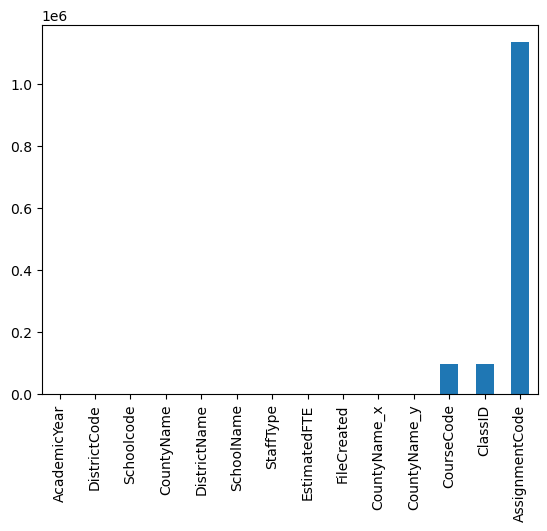

In [8]:
# Visualize number of null values.
StaffAssign16_recID_index_cp.isnull().sum().sort_values().plot(kind = 'bar')

In [9]:
# Removing null values.
StaffAssign16_recID_index_cp_drop_assignment_code = StaffAssign16_recID_index_cp.drop(columns = ['AssignmentCode'])
StaffAssign16_recID_index_cp_dropna = StaffAssign16_recID_index_cp_drop_assignment_code.dropna()

print(len(StaffAssign16_recID_index_cp_dropna))
StaffAssign16_recID_index_cp_dropna.head()

1133165


,AcademicYear,DistrictCode,Schoolcode,CountyName,DistrictName,SchoolName,StaffType,ClassID,CourseCode,EstimatedFTE,FileCreated,CountyName_x,CountyName_y
RecID,,,,,,,,,,,,,
1000428334,1617,0110017,0112607,Alameda,Alameda County Office of Education,Envision Academy for Arts & Technology,T,75002A12,2403,25.00,09/15/2017,Alameda,01
1000428334,1617,0110017,0112607,Alameda,Alameda County Office of Education,Envision Academy for Arts & Technology,T,75003A12,2403,25.00,09/15/2017,Alameda,01
1000428334,1617,0110017,0112607,Alameda,Alameda County Office of Education,Envision Academy for Arts & Technology,T,75001A12,2498,25.00,09/15/2017,Alameda,01
1000428334,1617,0110017,0112607,Alameda,Alameda County Office of Education,Envision Academy for Arts & Technology,T,75004A12,2498,25.00,09/15/2017,Alameda,01
1000413317,1617,0110017,6002000,Alameda,Alameda County Office of Education,Lazear Charter Academy,T,6445,2748,50.00,09/15/2017,Alameda,01


In [10]:
# Build a County-District-School (CDS) Code column that combines categorical values from the CountyName_x, DistrictCode_x,
# and SchoolCode columns of StaffAssign16_recID_index_cp_dropna.
# The reason why we are building a CDS Code column because that is what is used to identify schools as seen in the other
# datasets we have used in this Jupyter Notebook.
StaffAssign16_recID_index_cp_dropna['CDSCode'] = StaffAssign16_recID_index_cp_dropna['DistrictCode'].astype(str) + StaffAssign16_recID_index_cp_dropna['Schoolcode'].astype(str)
StaffAssign16_recID_index_cp_dropna.head()

,AcademicYear,DistrictCode,Schoolcode,CountyName,DistrictName,SchoolName,StaffType,ClassID,CourseCode,EstimatedFTE,FileCreated,CountyName_x,CountyName_y,CDSCode
RecID,,,,,,,,,,,,,,
1000428334,1617,0110017,0112607,Alameda,Alameda County Office of Education,Envision Academy for Arts & Technology,T,75002A12,2403,25.00,09/15/2017,Alameda,01,01100170112607
1000428334,1617,0110017,0112607,Alameda,Alameda County Office of Education,Envision Academy for Arts & Technology,T,75003A12,2403,25.00,09/15/2017,Alameda,01,01100170112607
1000428334,1617,0110017,0112607,Alameda,Alameda County Office of Education,Envision Academy for Arts & Technology,T,75001A12,2498,25.00,09/15/2017,Alameda,01,01100170112607
1000428334,1617,0110017,0112607,Alameda,Alameda County Office of Education,Envision Academy for Arts & Technology,T,75004A12,2498,25.00,09/15/2017,Alameda,01,01100170112607
1000413317,1617,0110017,6002000,Alameda,Alameda County Office of Education,Lazear Charter Academy,T,6445,2748,50.00,09/15/2017,Alameda,01,01100176002000


In [11]:
# Reset the index so we can eventually set the index as CDSCode.
StaffAssign16_recID_index_cp_reset_index = StaffAssign16_recID_index_cp_dropna.reset_index()
StaffAssign16_teachers_only = StaffAssign16_recID_index_cp_reset_index.query('StaffType == "T"')

# Extract the features of interest.
StaffAssign16_features = StaffAssign16_teachers_only[['CDSCode', 'EstimatedFTE']]

# Convert categorical values to numerical values
StaffAssign16_features['EstimatedFTE'] = pd.to_numeric(StaffAssign16_features['EstimatedFTE'])

In [12]:
# I'm only interested in teachers with some kind of employment at the school so staff members with FTE = 0.0 are removed.
StaffAssign16_fte_no_zero = StaffAssign16_features.query("EstimatedFTE > 0")

# For each school, calculate the average teaching experience (in years) of teachers and the average employment type
StaffAssign16_fte_averages = StaffAssign16_fte_no_zero.groupby('CDSCode').mean()
print(len(StaffAssign16_fte_averages))
StaffAssign16_fte_averages.head()

10065


,EstimatedFTE
CDSCode,
01100170112607,24.390244
01100170123968,100.000000
01100170124172,36.980000
01100170125567,91.666667
01100170130401,13.977018


### 2.5) Courses Taught

In [13]:
# Import data on courses taught for each school in California.
CoursesTaught16 = pd.read_csv("data/CoursesTaught16.txt", sep="\t", header=None, engine='python', encoding='latin-1', on_bad_lines='skip')
CoursesTaught16_df = CoursesTaught16.rename(columns=CoursesTaught16.iloc[0]).drop(CoursesTaught16.index[0])

CoursesTaught16_df['CDSCode'] = CoursesTaught16_df['DistrictCode'].astype(str) + CoursesTaught16_df['schoolCode'].astype(str)
CoursesTaught16_CDS_index = CoursesTaught16_df.set_index('CDSCode')
CoursesTaught16_CDS_index.head()

,AcademicYear,DistrictCode,schoolCode,CountyName,DistrictName,SchoolName,ClassID,CourseCode,ClassCourseID,UC CSU Approved,NCLB Core,NCLB HQT,DistanceLearning,IndependentStudy,MultipleTeacherCode,CTE FundingProvider,Enrollment,SEID Indicator,FileCreated
CDSCode,,,,,,,,,,,,,,,,,,,
01611196110779,1617,0161119,6110779,ALAMEDA,Alameda Unified,Bay Farm,10_Y_571_2,2734,4207973,N,N,NaN,N,N,NaN,NaN,29,Y,09/15/2017
01611190130229,1617,0161119,0130229,ALAMEDA,Alameda Unified,Alameda High,22_Y_3159_3,2404,4206304,Y,N,NaN,N,N,NaN,NaN,33,Y,09/15/2017
01611190119222,1617,0161119,0119222,ALAMEDA,Alameda Unified,Nea Community Learning Center,34032D9,6098,4205900,N,N,NaN,N,N,NaN,NaN,9,Y,09/15/2017
01611196090054,1617,0161119,6090054,ALAMEDA,Alameda Unified,Lincoln Middle,18_Y_390_1,2100,4207560,N,N,NaN,N,N,NaN,NaN,1,Y,09/15/2017
01611190130229,1617,0161119,0130229,ALAMEDA,Alameda Unified,Alameda High,22_Y_80_5,2132,4206604,Y,N,NaN,N,N,NaN,NaN,34,Y,09/15/2017


<AxesSubplot:>

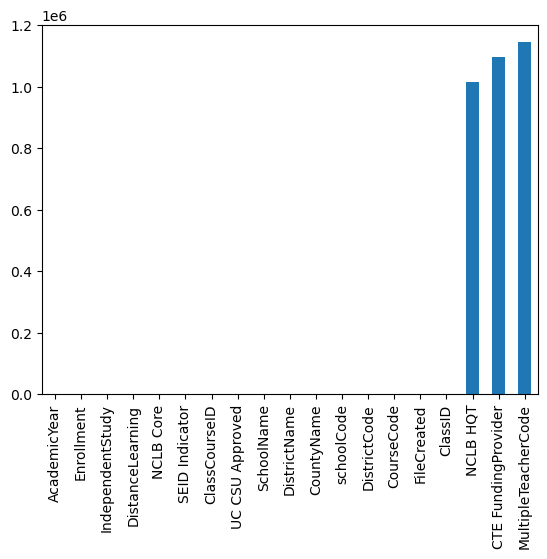

In [14]:
# Visualize the number of null values
CoursesTaught16_CDS_index.isnull().sum().sort_values().plot(kind='bar')

In [15]:
# Remove null values
CoursesTaught16_CDS_index_drop_col = CoursesTaught16_CDS_index.drop(columns = ['NCLB HQT', 'CTE FundingProvider', 'MultipleTeacherCode'])
CoursesTaught16_CDS_index_dropna = CoursesTaught16_CDS_index_drop_col.dropna()
CoursesTaught16_CDS_index_dropna.head()

,AcademicYear,DistrictCode,schoolCode,CountyName,DistrictName,SchoolName,ClassID,CourseCode,ClassCourseID,UC CSU Approved,NCLB Core,DistanceLearning,IndependentStudy,Enrollment,SEID Indicator,FileCreated
CDSCode,,,,,,,,,,,,,,,,
01611196110779,1617,0161119,6110779,ALAMEDA,Alameda Unified,Bay Farm,10_Y_571_2,2734,4207973,N,N,N,N,29,Y,09/15/2017
01611190130229,1617,0161119,0130229,ALAMEDA,Alameda Unified,Alameda High,22_Y_3159_3,2404,4206304,Y,N,N,N,33,Y,09/15/2017
01611190119222,1617,0161119,0119222,ALAMEDA,Alameda Unified,Nea Community Learning Center,34032D9,6098,4205900,N,N,N,N,9,Y,09/15/2017
01611196090054,1617,0161119,6090054,ALAMEDA,Alameda Unified,Lincoln Middle,18_Y_390_1,2100,4207560,N,N,N,N,1,Y,09/15/2017
01611190130229,1617,0161119,0130229,ALAMEDA,Alameda Unified,Alameda High,22_Y_80_5,2132,4206604,Y,N,N,N,34,Y,09/15/2017


In [16]:
# Extract the features of interest.
CoursesTaught16_CDS_index_dropna_features = CoursesTaught16_CDS_index_dropna[['UC CSU Approved', 'NCLB Core']]

# Replace Y with 1 and N with 0
CoursesTaught16_CDS_index_dropna_replace = CoursesTaught16_CDS_index_dropna_features.replace(to_replace = ['Y', 'N'], value = [1, 0])

# Reset Index
CoursesTaught16_CDS_reset_index = CoursesTaught16_CDS_index_dropna_replace.reset_index()

# For each school, calculate the average percentage of courses that were UC/CSU approved and were considered 
# NCLB Core classes
CoursesTaught16_CDS_averages = CoursesTaught16_CDS_reset_index.groupby('CDSCode').mean()
print(len(CoursesTaught16_CDS_averages))
CoursesTaught16_CDS_averages.head()

10098


,UC CSU Approved,NCLB Core
CDSCode,,
01100170112607,0.95122,0.0
01100170123968,0.00000,0.0
01100170124172,0.00000,0.0
01100170125567,0.00000,0.0
01100170130401,0.00000,0.0


### 2.6) Suspension Data

In [17]:
# Import data on number of suspensions for each school in California.
suspension1617 = pd.read_csv("data/suspension1617.txt", sep="\t", header=None, engine='python', encoding='latin-1', on_bad_lines='skip')
suspension1617_df = suspension1617.rename(columns=suspension1617.iloc[0]).drop(suspension1617.index[0])

# Generate "CDSCode" column by combining the CountyCode, DistrictCode, and SchoolCode columns
suspension1617_df['CDSCode'] = suspension1617_df['CountyCode'].astype(str) + suspension1617_df['DistrictCode'].astype(str) + suspension1617_df['SchoolCode'].astype(str)
suspension1617_CDS_index = suspension1617_df.set_index('CDSCode')

# Remove null values
suspension1617_dropna = suspension1617_CDS_index.dropna()
suspension1617_dropna_replace = suspension1617_dropna.replace('*', 0)

# Convert "Suspension Rate (Total)" object column to a float column
suspension1617_dropna_replace['Suspension Rate (Total)'] = suspension1617_dropna_replace['Suspension Rate (Total)'].astype(float)

# Reset index
suspension1617_reset = suspension1617_dropna_replace.reset_index()

# Convert "CDSCode" column to index
suspension1617_reset_CDS_index = suspension1617_reset.groupby('CDSCode').mean()
suspension1617_reset_CDS_index.head()

,Suspension Rate (Total)
CDSCode,
01100170000000,7.315094
01100170112607,7.523529
01100170123968,1.018750
01100170124172,0.453846
01100170125567,0.000000


### 2.7) English Learners

In [18]:
# Import data on number of English language learners (ELL) for each school in California.
ELL = pd.read_csv("data/english_learners16.txt", sep="\t", header=None, engine='python', encoding='latin-1', on_bad_lines='skip')
ELL_df = ELL.rename(columns=ELL.iloc[0]).drop(ELL.index[0])
ELL_df.rename(columns = {'GR_12':'GR_12_ELL', 'CDS':'CDSCode'}, inplace = True)

# Convert "GR_12_ELL" object column to float column
ELL_df['GR_12_ELL'] = ELL_df['GR_12_ELL'].astype(float)

# Add up all different ELL in grade 12 per school to find the total number of ELL per school
ELL_df_sum = ELL_df.groupby('CDSCode').sum()
ELL_df_sum.head()

,GR_12_ELL
CDSCode,
01100170112607,10.0
01100170123968,0.0
01100170124172,0.0
01100170125567,0.0
01100170130401,3.0


### 2.8) Chronic Absenteeism

In [19]:
# Import data on staff employment type for each school in California.
chronic_absent = pd.read_csv("data/chronic_absent.txt", sep="\t", header=None, engine='python', encoding='latin-1', on_bad_lines='skip')
chronic_absent_df = chronic_absent.rename(columns=chronic_absent.iloc[0]).drop(chronic_absent.index[0])

# Generate "CDSCode" column by combining the CountyCode, DistrictCode, and SchoolCode columns
chronic_absent_df['CDSCode'] = chronic_absent_df['CountyCode'].astype(str) + chronic_absent_df['DistrictCode'].astype(str) + chronic_absent_df['SchoolCode'].astype(str)
chronic_absent_df['ChronicAbsenteeismRate'] = chronic_absent_df['ChronicAbsenteeismRate'].astype(float)

# Remove null values
chronic_absent_dropna = chronic_absent_df.dropna()

# Groupby the CDSCode column and find the average Chronic Absenteeism Rate
chronic_absent_CDS_index = chronic_absent_dropna.groupby('CDSCode').mean()
chronic_absent_CDS_index.head()

,ChronicAbsenteeismRate
CDSCode,
01100170000000,31.196923
01100170112607,23.060000
01100170123968,17.300000
01100170124172,5.580000
01100170125567,12.633333


## 3) Merge dataframes together

Once we have all the individual dataframes organized with all the features of interest, we can combine all the dataframes.

### 3.1) Merge public_hs_copy with grad_UC_CSU_index_copy_df_rename

In [36]:
public_school_UC_CSU = pd.merge(left = public_hs_copy, right = grad_UC_CSU_index_copy_df_rename, left_on = 'CDSCode', right_on = 'CDSCode', how = 'inner')

print(len(public_school_UC_CSU))
public_school_UC_CSU.head()

1873


,City,Charter,Virtual,Magnet,YearRoundYN,Number of UC/CSU-ready students
CDSCode,,,,,,
01100170130401,San Leandro,0,N,0.0,0,0.0
01100170130419,Hayward,0,C,0.0,0,0.0
01611190106401,Alameda,0,N,1.0,1,42.0
01611190130229,Alameda,0,N,0.0,1,262.0
01611190134304,Alameda,0,N,0.0,1,0.0


### 3.2) Merge public_school_UC_CSU with grade_12_enroll_features_sum_rename

In [21]:
public_school_UC_CSU_grd_12 = pd.merge(left = public_school_UC_CSU, right = grade_12_enroll_features_sum_rename, left_on = 'CDSCode', right_on = 'CDSCode', how = 'inner')

print(len(public_school_UC_CSU_grd_12))
public_school_UC_CSU_grd_12.head()

1866


,City,Charter,Virtual,Magnet,YearRoundYN,Number of UC/CSU-ready students,Total number of students in GR12
CDSCode,,,,,,,
01100170130401,San Leandro,0,N,0.0,0,0.0,39.0
01100170130419,Hayward,0,C,0.0,0,0.0,133.0
01611190106401,Alameda,0,N,1.0,1,42.0,44.0
01611190130229,Alameda,0,N,0.0,1,262.0,419.0
01611190134304,Alameda,0,N,0.0,1,0.0,99.0


### 3.3) Merge public_school_UC_CSU_grd_12 with hs_frmp_index[["Percent (%) \nEligible FRPM \n(K-12)"]]

In [22]:
public_school_UC_CSU_grd_12_frmp = pd.merge(left = public_school_UC_CSU_grd_12, right = hs_frmp_index[["Percent (%) \nEligible FRPM \n(K-12)"]], left_on = 'CDSCode', right_on = 'CDSCode', how = 'inner')

print(len(public_school_UC_CSU_grd_12_frmp))
public_school_UC_CSU_grd_12_frmp.head()

1203


,City,Charter,Virtual,Magnet,YearRoundYN,Number of UC/CSU-ready students,Total number of students in GR12,Percent (%) \nEligible FRPM \n(K-12)
CDSCode,,,,,,,,
01611190130229,Alameda,0,N,0.0,1,262.0,419.0,18.9%
01611270130450,Albany,0,N,0.0,0,175.0,295.0,18.2%
01611430131177,Berkeley,0,N,0.0,0,35.0,781.0,27.9%
01611500132225,Castro Valley,0,N,0.0,0,408.0,714.0,22.0%
01611680132746,Emeryville,0,N,0.0,0,11.0,35.0,68.9%


### 3.4) Merge public_school_UC_CSU_grd_12_frmp with StaffAssign16_fte_averages ¶

In [23]:
public_school_UC_CSU_grd_12_frmp_fte = pd.merge(left = public_school_UC_CSU_grd_12_frmp, right = StaffAssign16_fte_averages, left_on = 'CDSCode', right_on = 'CDSCode', how = 'inner')

print(len(public_school_UC_CSU_grd_12_frmp_fte))
public_school_UC_CSU_grd_12_frmp_fte.head()

1200


,City,Charter,Virtual,Magnet,YearRoundYN,Number of UC/CSU-ready students,Total number of students in GR12,Percent (%) \nEligible FRPM \n(K-12),EstimatedFTE
CDSCode,,,,,,,,,
01611190130229,Alameda,0,N,0.0,1,262.0,419.0,18.9%,14.757510
01611270130450,Albany,0,N,0.0,0,175.0,295.0,18.2%,17.802918
01611430131177,Berkeley,0,N,0.0,0,35.0,781.0,27.9%,21.396801
01611500132225,Castro Valley,0,N,0.0,0,408.0,714.0,22.0%,19.954172
01611680132746,Emeryville,0,N,0.0,0,11.0,35.0,68.9%,19.720423


### 3.5) Merge public_school_UC_CSU_grd_12_frmp_fte with CoursesTaught16_CDS_averages

In [24]:
public_school_UC_CSU_grd_12_frmp_fte_course = pd.merge(left = public_school_UC_CSU_grd_12_frmp_fte, right = CoursesTaught16_CDS_averages, left_on = 'CDSCode', right_on = 'CDSCode', how = 'inner')

print(len(public_school_UC_CSU_grd_12_frmp_fte_course))
public_school_UC_CSU_grd_12_frmp_fte_course.head()

1200


,City,Charter,Virtual,Magnet,YearRoundYN,Number of UC/CSU-ready students,Total number of students in GR12,Percent (%) \nEligible FRPM \n(K-12),EstimatedFTE,UC CSU Approved,NCLB Core
CDSCode,,,,,,,,,,,
01611190130229,Alameda,0,N,0.0,1,262.0,419.0,18.9%,14.757510,0.509328,0.0
01611270130450,Albany,0,N,0.0,0,175.0,295.0,18.2%,17.802918,0.713018,0.0
01611430131177,Berkeley,0,N,0.0,0,35.0,781.0,27.9%,21.396801,0.827632,0.0
01611500132225,Castro Valley,0,N,0.0,0,408.0,714.0,22.0%,19.954172,0.805000,0.0
01611680132746,Emeryville,0,N,0.0,0,11.0,35.0,68.9%,19.720423,0.000000,0.0


### 3.6) Merge public_school_UC_CSU_grd_12_frmp_fte_course with suspension1617_reset_CDS_index

In [25]:
public_school_UC_CSU_grd_12_frmp_fte_course_suspend = pd.merge(left = public_school_UC_CSU_grd_12_frmp_fte_course, right = suspension1617_reset_CDS_index, left_on = 'CDSCode', right_on = 'CDSCode', how = 'inner')

print(len(public_school_UC_CSU_grd_12_frmp_fte_course_suspend))
public_school_UC_CSU_grd_12_frmp_fte_course_suspend.head()

1200


,City,Charter,Virtual,Magnet,YearRoundYN,Number of UC/CSU-ready students,Total number of students in GR12,Percent (%) \nEligible FRPM \n(K-12),EstimatedFTE,UC CSU Approved,NCLB Core,Suspension Rate (Total)
CDSCode,,,,,,,,,,,,
01611190130229,Alameda,0,N,0.0,1,262.0,419.0,18.9%,14.757510,0.509328,0.0,2.911765
01611270130450,Albany,0,N,0.0,0,175.0,295.0,18.2%,17.802918,0.713018,0.0,2.482353
01611430131177,Berkeley,0,N,0.0,0,35.0,781.0,27.9%,21.396801,0.827632,0.0,2.964706
01611500132225,Castro Valley,0,N,0.0,0,408.0,714.0,22.0%,19.954172,0.805000,0.0,9.152941
01611680132746,Emeryville,0,N,0.0,0,11.0,35.0,68.9%,19.720423,0.000000,0.0,2.386667


### 3.7) Merge public_school_UC_CSU_grd_12_frmp_fte_course_suspend with ELL_df_sum

In [26]:
public_school_UC_CSU_grd_12_frmp_fte_course_suspend_ELL = pd.merge(left = public_school_UC_CSU_grd_12_frmp_fte_course_suspend, right = ELL_df_sum, left_on = 'CDSCode', right_on = 'CDSCode', how = 'inner')

print(len(public_school_UC_CSU_grd_12_frmp_fte_course_suspend_ELL))
public_school_UC_CSU_grd_12_frmp_fte_course_suspend_ELL.head()

1166


,City,Charter,Virtual,Magnet,YearRoundYN,Number of UC/CSU-ready students,Total number of students in GR12,Percent (%) \nEligible FRPM \n(K-12),EstimatedFTE,UC CSU Approved,NCLB Core,Suspension Rate (Total),GR_12_ELL
CDSCode,,,,,,,,,,,,,
01611190130229,Alameda,0,N,0.0,1,262.0,419.0,18.9%,14.757510,0.509328,0.0,2.911765,40.0
01611270130450,Albany,0,N,0.0,0,175.0,295.0,18.2%,17.802918,0.713018,0.0,2.482353,18.0
01611430131177,Berkeley,0,N,0.0,0,35.0,781.0,27.9%,21.396801,0.827632,0.0,2.964706,41.0
01611500132225,Castro Valley,0,N,0.0,0,408.0,714.0,22.0%,19.954172,0.805000,0.0,9.152941,31.0
01611680132746,Emeryville,0,N,0.0,0,11.0,35.0,68.9%,19.720423,0.000000,0.0,2.386667,4.0


### 3.8) Merge public_school_UC_CSU_grd_12_frmp_fte_course_suspend_ELL with chronic_absent_CDS_index

In [27]:
df = pd.merge(left = public_school_UC_CSU_grd_12_frmp_fte_course_suspend_ELL, right = chronic_absent_CDS_index, left_on = 'CDSCode', right_on = 'CDSCode', how = 'inner')

print(len(df))
df.head()

1165


,City,Charter,Virtual,Magnet,YearRoundYN,Number of UC/CSU-ready students,Total number of students in GR12,Percent (%) \nEligible FRPM \n(K-12),EstimatedFTE,UC CSU Approved,NCLB Core,Suspension Rate (Total),GR_12_ELL,ChronicAbsenteeismRate
CDSCode,,,,,,,,,,,,,,
01611190130229,Alameda,0,N,0.0,1,262.0,419.0,18.9%,14.757510,0.509328,0.0,2.911765,40.0,12.193333
01611270130450,Albany,0,N,0.0,0,175.0,295.0,18.2%,17.802918,0.713018,0.0,2.482353,18.0,8.984615
01611430131177,Berkeley,0,N,0.0,0,35.0,781.0,27.9%,21.396801,0.827632,0.0,2.964706,41.0,20.537500
01611500132225,Castro Valley,0,N,0.0,0,408.0,714.0,22.0%,19.954172,0.805000,0.0,9.152941,31.0,12.635294
01611680132746,Emeryville,0,N,0.0,0,11.0,35.0,68.9%,19.720423,0.000000,0.0,2.386667,4.0,21.209091


## 4) Data Cleaning

In this step, the data in our dataframe with set features, df, will be cleaned to prepare for dataprocessing.

### 4.1) Convert "Percent (%) Eligible FRPM (K-12)" object column to float column

In [28]:
df_cp = df.copy()

df_cp['Percent (%) \nEligible FRPM \n(K-12)'] = df_cp['Percent (%) \nEligible FRPM \n(K-12)'].str.replace('%','')
df_cp['Percent (%) \nEligible FRPM \n(K-12)'] = df_cp['Percent (%) \nEligible FRPM \n(K-12)'].astype(float)
df_cp.head()

,City,Charter,Virtual,Magnet,YearRoundYN,Number of UC/CSU-ready students,Total number of students in GR12,Percent (%) \nEligible FRPM \n(K-12),EstimatedFTE,UC CSU Approved,NCLB Core,Suspension Rate (Total),GR_12_ELL,ChronicAbsenteeismRate
CDSCode,,,,,,,,,,,,,,
01611190130229,Alameda,0,N,0.0,1,262.0,419.0,18.9,14.757510,0.509328,0.0,2.911765,40.0,12.193333
01611270130450,Albany,0,N,0.0,0,175.0,295.0,18.2,17.802918,0.713018,0.0,2.482353,18.0,8.984615
01611430131177,Berkeley,0,N,0.0,0,35.0,781.0,27.9,21.396801,0.827632,0.0,2.964706,41.0,20.537500
01611500132225,Castro Valley,0,N,0.0,0,408.0,714.0,22.0,19.954172,0.805000,0.0,9.152941,31.0,12.635294
01611680132746,Emeryville,0,N,0.0,0,11.0,35.0,68.9,19.720423,0.000000,0.0,2.386667,4.0,21.209091


### 4.2) Calculate percentage of students who are UC/CSU-ready (i.e. "Number of UC/CSU-ready students" / "Total number of students in GR12")

In [29]:
# Calculate the percentage of students in grade 12 who are UC/CSU-ready
df_cp_copy = df_cp.copy()

df_cp_copy['%_UC_CSU_ready'] = df_cp_copy['Number of UC/CSU-ready students']/df_cp_copy['Total number of students in GR12']
df_cp_copy.head()

,City,Charter,Virtual,Magnet,YearRoundYN,Number of UC/CSU-ready students,Total number of students in GR12,Percent (%) \nEligible FRPM \n(K-12),EstimatedFTE,UC CSU Approved,NCLB Core,Suspension Rate (Total),GR_12_ELL,ChronicAbsenteeismRate,%_UC_CSU_ready
CDSCode,,,,,,,,,,,,,,,
01611190130229,Alameda,0,N,0.0,1,262.0,419.0,18.9,14.757510,0.509328,0.0,2.911765,40.0,12.193333,0.625298
01611270130450,Albany,0,N,0.0,0,175.0,295.0,18.2,17.802918,0.713018,0.0,2.482353,18.0,8.984615,0.593220
01611430131177,Berkeley,0,N,0.0,0,35.0,781.0,27.9,21.396801,0.827632,0.0,2.964706,41.0,20.537500,0.044814
01611500132225,Castro Valley,0,N,0.0,0,408.0,714.0,22.0,19.954172,0.805000,0.0,9.152941,31.0,12.635294,0.571429
01611680132746,Emeryville,0,N,0.0,0,11.0,35.0,68.9,19.720423,0.000000,0.0,2.386667,4.0,21.209091,0.314286


### 4.3) Calculate percentage if students who are English language learners (i.e. "GR_12_ELL" / "Total number of students in GR12")

In [30]:
df_cp_copy["%_GR_12_ELL"] = df_cp_copy["GR_12_ELL"]/df_cp_copy['Total number of students in GR12']
df_cp_copy.head()

,City,Charter,Virtual,Magnet,YearRoundYN,Number of UC/CSU-ready students,Total number of students in GR12,Percent (%) \nEligible FRPM \n(K-12),EstimatedFTE,UC CSU Approved,NCLB Core,Suspension Rate (Total),GR_12_ELL,ChronicAbsenteeismRate,%_UC_CSU_ready,%_GR_12_ELL
CDSCode,,,,,,,,,,,,,,,,
01611190130229,Alameda,0,N,0.0,1,262.0,419.0,18.9,14.757510,0.509328,0.0,2.911765,40.0,12.193333,0.625298,0.095465
01611270130450,Albany,0,N,0.0,0,175.0,295.0,18.2,17.802918,0.713018,0.0,2.482353,18.0,8.984615,0.593220,0.061017
01611430131177,Berkeley,0,N,0.0,0,35.0,781.0,27.9,21.396801,0.827632,0.0,2.964706,41.0,20.537500,0.044814,0.052497
01611500132225,Castro Valley,0,N,0.0,0,408.0,714.0,22.0,19.954172,0.805000,0.0,9.152941,31.0,12.635294,0.571429,0.043417
01611680132746,Emeryville,0,N,0.0,0,11.0,35.0,68.9,19.720423,0.000000,0.0,2.386667,4.0,21.209091,0.314286,0.114286


### 4.4) Drop the "Number of UC/CSU-ready students", "GR_12_ELL", and "Total number of students in GR12" columns

In [31]:
df_cp_copy_drop = df_cp_copy.drop(columns = ['Number of UC/CSU-ready students', 'GR_12_ELL', 'Total number of students in GR12'])
df_cp_copy_drop.head()

,City,Charter,Virtual,Magnet,YearRoundYN,Percent (%) \nEligible FRPM \n(K-12),EstimatedFTE,UC CSU Approved,NCLB Core,Suspension Rate (Total),ChronicAbsenteeismRate,%_UC_CSU_ready,%_GR_12_ELL
CDSCode,,,,,,,,,,,,,
01611190130229,Alameda,0,N,0.0,1,18.9,14.757510,0.509328,0.0,2.911765,12.193333,0.625298,0.095465
01611270130450,Albany,0,N,0.0,0,18.2,17.802918,0.713018,0.0,2.482353,8.984615,0.593220,0.061017
01611430131177,Berkeley,0,N,0.0,0,27.9,21.396801,0.827632,0.0,2.964706,20.537500,0.044814,0.052497
01611500132225,Castro Valley,0,N,0.0,0,22.0,19.954172,0.805000,0.0,9.152941,12.635294,0.571429,0.043417
01611680132746,Emeryville,0,N,0.0,0,68.9,19.720423,0.000000,0.0,2.386667,21.209091,0.314286,0.114286


### 4.5) Leave-one-out-encoding for the "Virtual" and "City" columns to result in a dataframe containing all numeric values.

In [32]:
# leave-one-out-encoding for "Virtual" and "City" columns
encoder = ce.LeaveOneOutEncoder(return_df = True)
df_loo = encoder.fit_transform(df_cp_copy_drop, df_cp_copy_drop['%_UC_CSU_ready'])
df_loo.head()

,City,Charter,Virtual,Magnet,YearRoundYN,Percent (%) \nEligible FRPM \n(K-12),EstimatedFTE,UC CSU Approved,NCLB Core,Suspension Rate (Total),ChronicAbsenteeismRate,%_UC_CSU_ready,%_GR_12_ELL
CDSCode,,,,,,,,,,,,,
01611190130229,0.46437,0,0.467330,0.0,1,18.9,14.757510,0.509328,0.0,2.911765,12.193333,0.625298,0.095465
01611270130450,0.46437,0,0.467373,0.0,0,18.2,17.802918,0.713018,0.0,2.482353,8.984615,0.593220,0.061017
01611430131177,0.46437,0,0.468104,0.0,0,27.9,21.396801,0.827632,0.0,2.964706,20.537500,0.044814,0.052497
01611500132225,0.46437,0,0.467402,0.0,0,22.0,19.954172,0.805000,0.0,9.152941,12.635294,0.571429,0.043417
01611680132746,0.46437,0,0.467745,0.0,0,68.9,19.720423,0.000000,0.0,2.386667,21.209091,0.314286,0.114286


### 4.6) Standardize columns

Standardize all columns except for columns containing binary values and the target values (i.e., the following columns were not standardized: "Charter", "Magnet", "YearRoundYN", and the target column, %_UC_CSU_ready).

The dataframe, df_loo_cp, will be the dataframe that is used to generate a machine learning model.

In [34]:
scaler = StandardScaler()

df_loo_cp = df_loo.copy()

df_loo_cp[['City','Virtual', 'Percent (%) \nEligible FRPM \n(K-12)', 'EstimatedFTE', 'UC CSU Approved', 'NCLB Core', 'Suspension Rate (Total)', '%_GR_12_ELL', 'ChronicAbsenteeismRate']] = scaler.fit_transform(df_loo_cp[['City','Virtual', 'Percent (%) \nEligible FRPM \n(K-12)', 'EstimatedFTE', 'UC CSU Approved', 'NCLB Core', 'Suspension Rate (Total)', '%_GR_12_ELL', 'ChronicAbsenteeismRate']])
df_loo_cp.head()

,City,Charter,Virtual,Magnet,YearRoundYN,Percent (%) \nEligible FRPM \n(K-12),EstimatedFTE,UC CSU Approved,NCLB Core,Suspension Rate (Total),ChronicAbsenteeismRate,%_UC_CSU_ready,%_GR_12_ELL
CDSCode,,,,,,,,,,,,,
01611190130229,-0.070175,0,0.082922,0.0,1,-1.438061,-0.404712,-0.439639,-0.332477,-0.454456,-0.390380,0.625298,0.016395
01611270130450,-0.070175,0,0.084120,0.0,0,-1.464424,0.046755,0.666281,-0.332477,-0.566584,-0.663015,0.593220,-0.347121
01611430131177,-0.070175,0,0.104602,0.0,0,-1.099108,0.579530,1.288570,-0.332477,-0.440632,0.318596,0.044814,-0.437030
01611500132225,-0.070175,0,0.084934,0.0,0,-1.321310,0.365667,1.165693,-0.332477,1.175247,-0.352828,0.571429,-0.532840
01611680132746,-0.070175,0,0.094538,0.0,0,0.445009,0.331015,-3.205009,-0.332477,-0.591570,0.375659,0.314286,0.214996


## 5) Visualize data

### 5.1) Plot a heatmap to visualize the correlation between the target variable and the other categorical features

The largest magnitude of correlations that were found from heatmap are those between 0.40 and 0.46. Below are the information we found from the heatmap.

1) As the percentage of students who are eligible for free/reduced-priced meals increases, the percentage of students who are English language learners tends to increase.

2) As the number of classes in a school that are UC/CSU-approved increases, the percentage of students in the school who are UC/CSU-ready tends to increase.

3) As the percentage of 12th grade students who are English language learners at a school increases, the rate of chronic absenteeism tends to increase.

4) As the rate of chronic absenteeism increases, the percentage of students who are UC/CSU-ready tends to decrease.

Text(188.32222222222222, 0.5, 'column names')

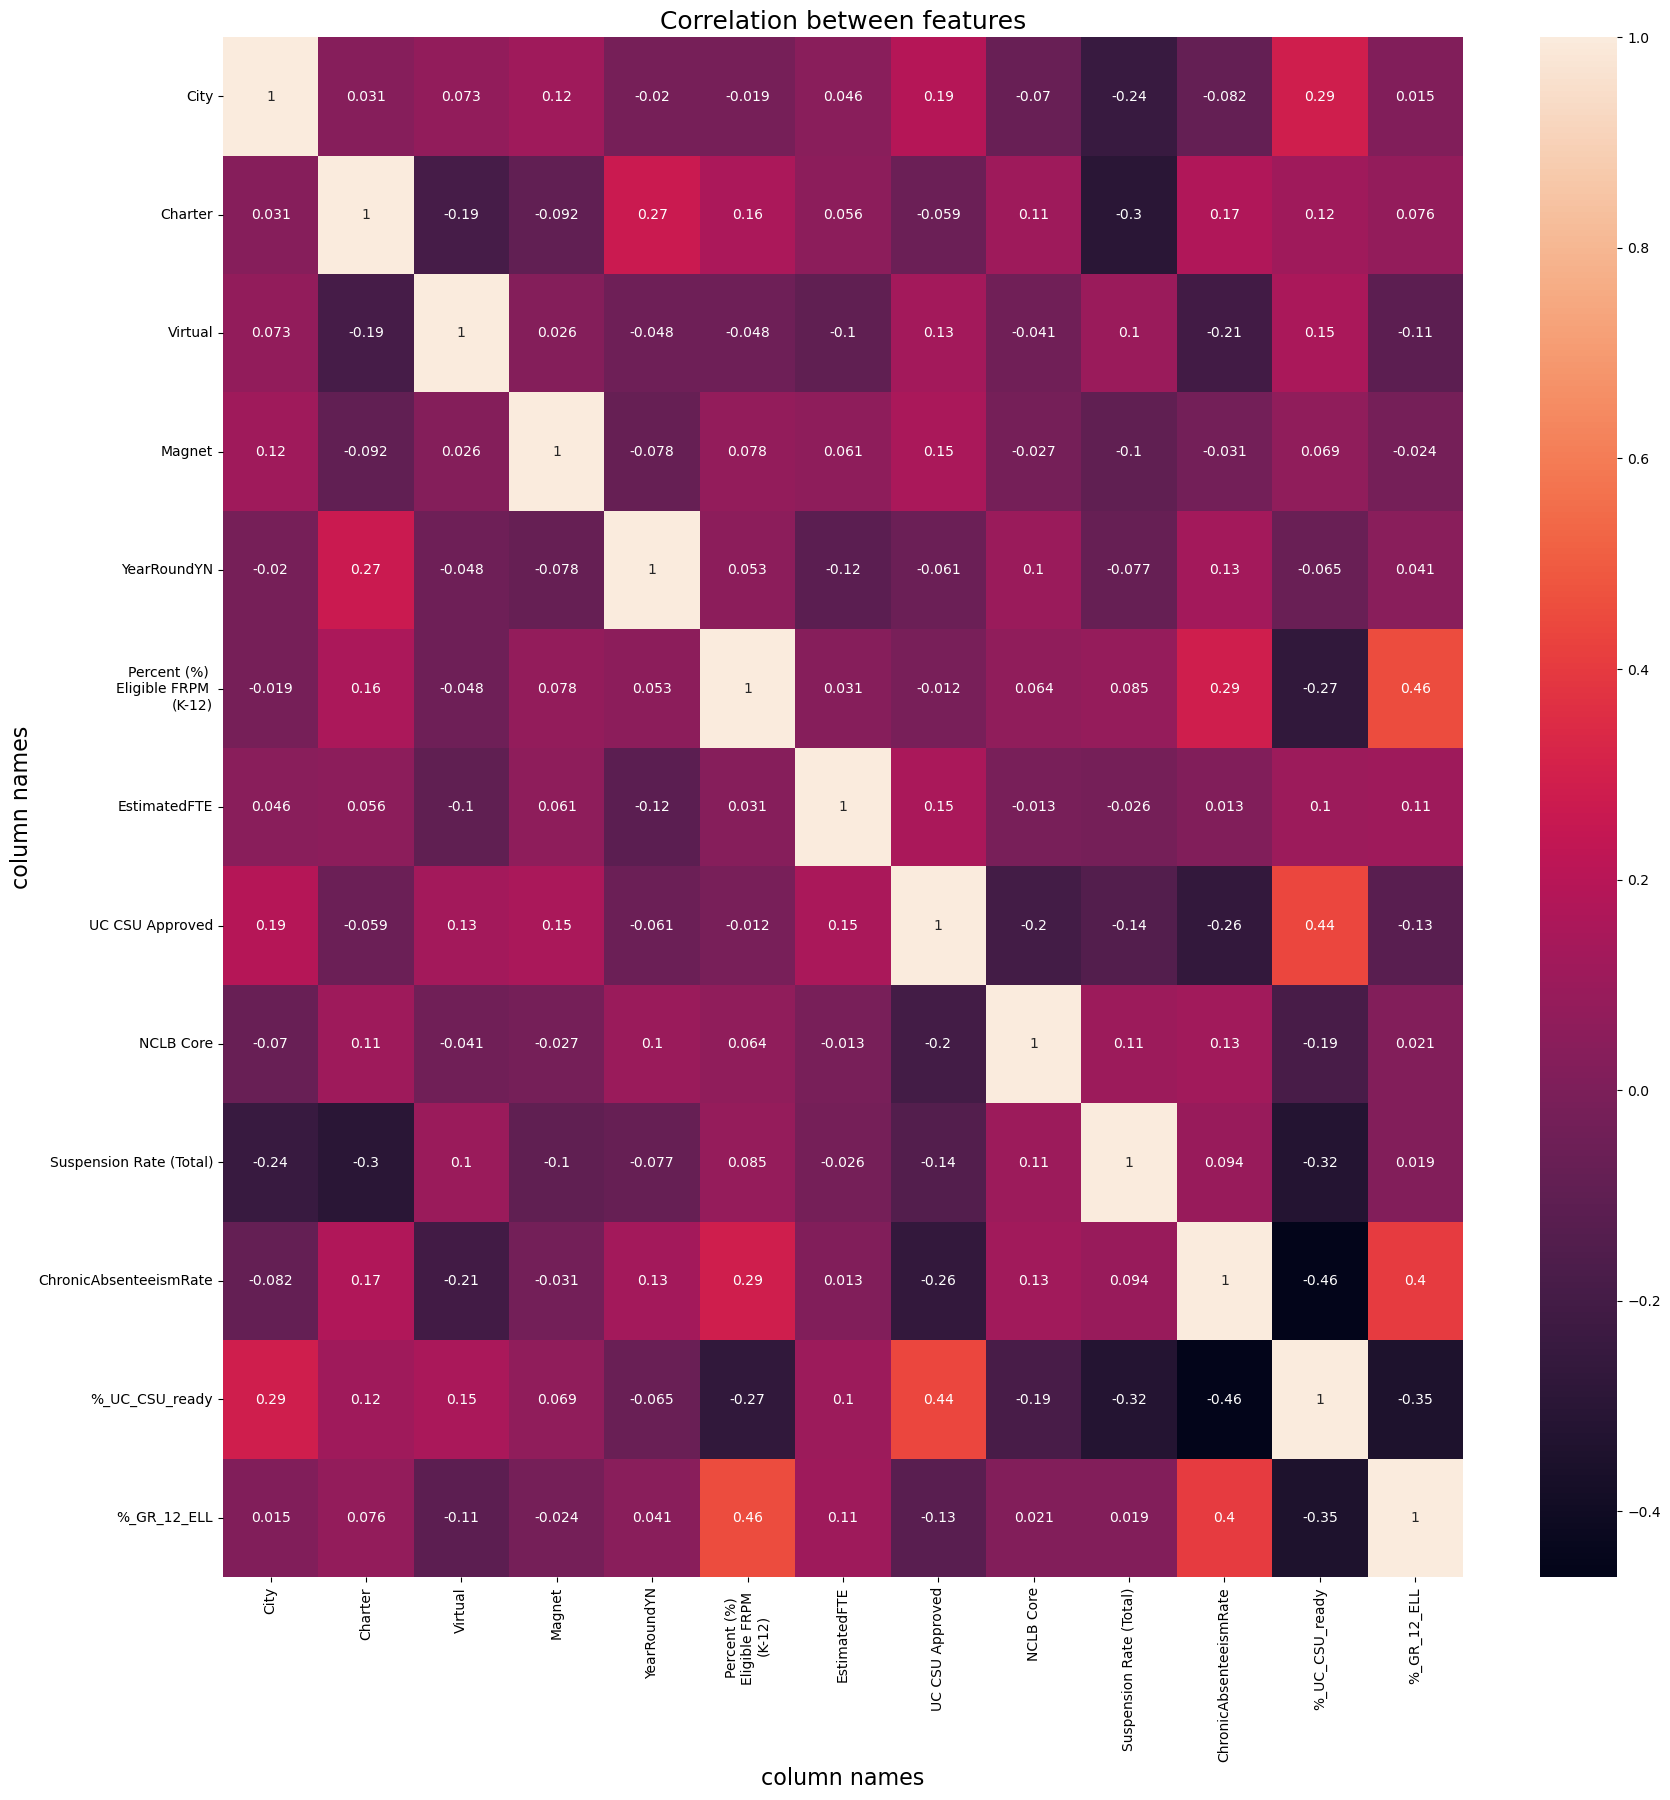

In [60]:
plt.figure(figsize=(20,20))
sns.heatmap(df_loo_cp.corr(), annot=True)
plt.title('Correlation between features', fontsize = 18)
plt.xlabel('column names', fontsize=16)
plt.ylabel('column names', fontsize=16)

### 5.2) Number of 12th grade classrooms that have no virtual options (N), are primarily structured in person (C), are primarily virtual (V), and exclusively virtual (F)

<AxesSubplot:xlabel='Virtual', ylabel='Count'>

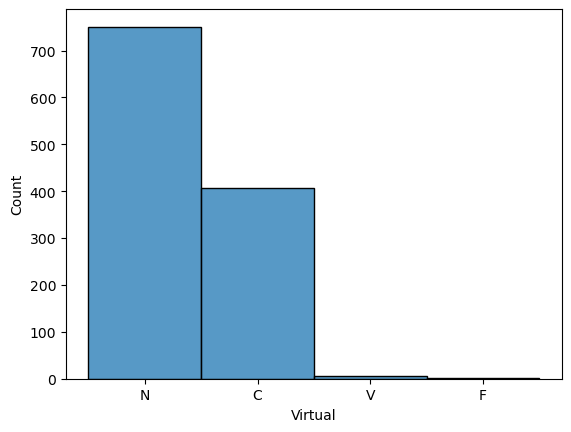

In [62]:
sns.histplot(data=df_cp_copy_drop, x="Virtual")

### 5.3) Number of California high schools that are Charter schools

<AxesSubplot:xlabel='Charter', ylabel='Count'>

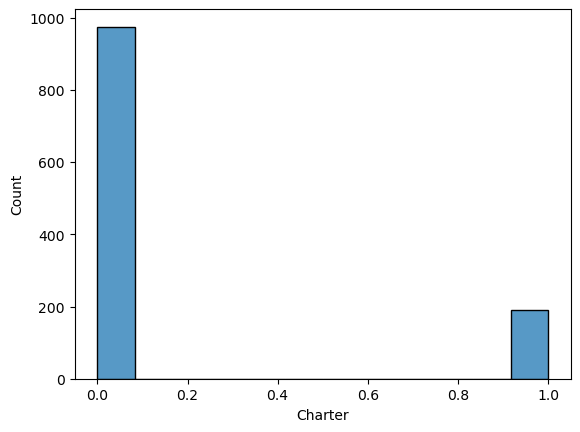

In [65]:
sns.histplot(data=df_cp_copy_drop, x="Charter")

# School is charter school = 1; School is NOT charter school = 0

### 5.4) Number of California high schools that are Magnet schools

<AxesSubplot:xlabel='Magnet', ylabel='Count'>

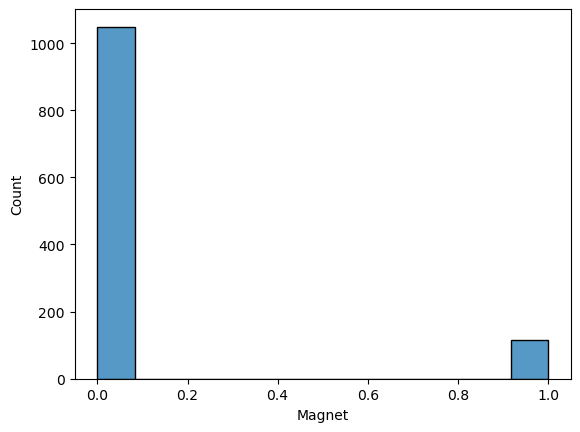

In [66]:
sns.histplot(data=df_cp_copy_drop, x="Magnet")

# School is magnet school = 1; School is NOT magnet school = 0

### 5.5) Number of California high schools that are Year-Round schools

<AxesSubplot:xlabel='YearRoundYN', ylabel='Count'>

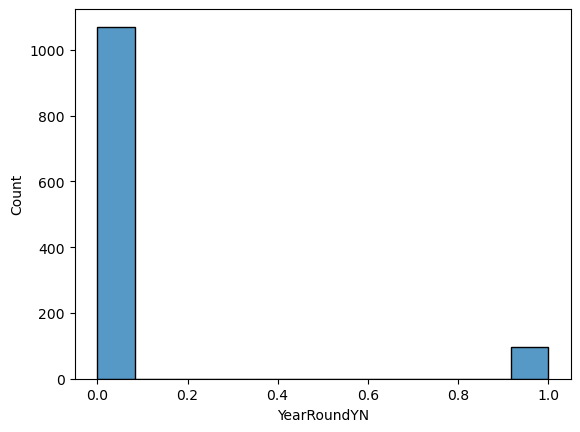

In [68]:
sns.histplot(data=df_cp_copy_drop, x="YearRoundYN")

# School is a year-round school = 1; School is NOT a year-round school = 0

## 6) Split the data into a training and test set

In [35]:
X = df_loo_cp.drop(['%_UC_CSU_ready'], axis=1)
y = df_loo_cp['%_UC_CSU_ready']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

## 7) Model

In this section, I tried out different types of regression models. The first model I tried was a linear regression model and the second was an ensemble model. When the linear regression model was used, the model had an accuracy of 48%. However, when the ensemble model was used, the model had a higher accuracy of 75-77%. Therefore, the ensemble model is a better machine learning model to use instead of only using the linear regression model.

### 7.1) Linear regression model

#### 7.1.1) Loading the linear regression model and fitting the model to dataset

In [37]:
# Loading the linear regression model
lin_reg_model = LinearRegression()

In [38]:
# fit the model to dataset
lin_reg_model.fit(X_train, y_train)

LinearRegression()

#### 7.1.2) Calculating training and test mean squared errors

In [39]:
y_pred_train = lin_reg_model.predict(X_train)
train_mse = mean_squared_error(y_train, y_pred_train)
train_mse

0.025600546918429026

In [40]:
y_pred_test = lin_reg_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_pred_test)
test_mse

0.02730253213584544

#### 7.1.3) Calculating the accuracy of the model

In [41]:
lin_reg_accuracy = lin_reg_model.score(X_train,y_train)
lin_reg_accuracy

0.4803863506141284

### 7.2) Ensemble of regression models

#### 7.2.1) Loading the voting regressor ensemble model and fitting the model to dataset

In [46]:
voter = VotingRegressor([('lr', LinearRegression()), ('knr', KNeighborsRegressor()), 
                             ('tree', DecisionTreeRegressor()), ('ridge', Ridge()),
                            ('svr', SVR())])
voter.fit(X_train, y_train)

VotingRegressor(estimators=[('lr', LinearRegression()),
                            ('knr', KNeighborsRegressor()),
                            ('tree', DecisionTreeRegressor()),
                            ('ridge', Ridge()), ('svr', SVR())])

#### 7.2.2) Calculating training and test mean squared errors

In [43]:
y_pred_train_voter = voter.predict(X_train)
voter_train_mse = mean_squared_error(y_train, y_pred_train_voter)
voter_train_mse

0.01133649197471544

In [44]:
y_pred_test_voter = voter.predict(X_test)
voter_test_mse = mean_squared_error(y_test, y_pred_test_voter)
voter_test_mse

0.014758171254386191

#### 7.2.3) Calculating the accuracy of the model

In [45]:
voter_accuracy = voter.score(X_train, y_train)
voter_accuracy

0.7699035108513607

#### 7.2.4) Using GridSearchCV to tune the hyperparameters of the voting regressor model for a potential higher machine learning model accuracy

In [47]:
grid_params = {'knr__n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17],
              'tree__criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
              'tree__max_depth': [None, 3, 5, 7, 9, 11, 13, 15, 17],
              'ridge__alpha': [0.1, 1.0, 10.0, 100.0],
               'ridge__max_iter': [15000],
               'svr__degree': [1, 2, 3, 4, 5]
              }

In [48]:
voter_grid = GridSearchCV(voter, param_grid = grid_params, cv = 2)
voter_grid.fit(X_train, y_train)

GridSearchCV(cv=2,
             estimator=VotingRegressor(estimators=[('lr', LinearRegression()),
                                                   ('knr',
                                                    KNeighborsRegressor()),
                                                   ('tree',
                                                    DecisionTreeRegressor()),
                                                   ('ridge', Ridge()),
                                                   ('svr', SVR())]),
             param_grid={'knr__n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17],
                         'ridge__alpha': [0.1, 1.0, 10.0, 100.0],
                         'ridge__max_iter': [15000],
                         'svr__degree': [1, 2, 3, 4, 5],
                         'tree__criterion': ['squared_error', 'friedman_mse',
                                             'absolute_error', 'poisson'],
                         'tree__max_depth': [None, 3, 5, 7, 9, 11, 13, 15, 17]})

In [49]:
voter_grid.best_params_

{'knr__n_neighbors': 7,
 'ridge__alpha': 0.1,
 'ridge__max_iter': 15000,
 'svr__degree': 3,
 'tree__criterion': 'absolute_error',
 'tree__max_depth': 9}

#### 7.2.5) Use best parameters to model data

In [51]:
voter_best = VotingRegressor([('lr', LinearRegression()), ('knr', KNeighborsRegressor(n_neighbors = 7)), 
                             ('tree', DecisionTreeRegressor(criterion = 'absolute_error', max_depth = 9)), ('ridge', Ridge(alpha = 0.1)),
                            ('svr', SVR(degree = 3))])
voter_best.fit(X_train, y_train)

VotingRegressor(estimators=[('lr', LinearRegression()),
                            ('knr', KNeighborsRegressor(n_neighbors=7)),
                            ('tree',
                             DecisionTreeRegressor(criterion='absolute_error',
                                                   max_depth=9)),
                            ('ridge', Ridge(alpha=0.1)), ('svr', SVR())])

#### Calculating training and test mean squared errors

In [52]:
y_pred_train_voter_best = voter_best.predict(X_train)
voter_best_train_mse = mean_squared_error(y_train, y_pred_train_voter_best)
voter_best_train_mse

0.01237575156692914

In [53]:
y_pred_test_voter_best = voter_best.predict(X_test)
voter_best_test_mse = mean_squared_error(y_test, y_pred_test_voter_best)
voter_best_test_mse

0.014874736115352316

#### Calculating the accuracy of the model

In [54]:
voter_accuracy_best = voter_best.score(X_train, y_train)
voter_accuracy_best

0.7488096853526292

## 8) Identifying the features of the greatest importance

In [59]:
result = permutation_importance(
    estimator = voter_best,
    X = X_test,
    y = y_test,
    scoring = 'r2',
    n_repeats = 50,
    random_state = 42
)
print(len(result.importances))
result

12


{'importances_mean': array([0.04998141, 0.09193171, 0.16472834, 0.00151396, 0.00214096,
        0.04706844, 0.02731061, 0.10357365, 0.02873918, 0.07034791,
        0.07281718, 0.04764456]),
 'importances_std': array([0.00935644, 0.01223478, 0.01750479, 0.00097209, 0.00102905,
        0.00774874, 0.00474345, 0.01658952, 0.00623243, 0.00976217,
        0.01498055, 0.01423104]),
 'importances': array([[ 4.53900696e-02,  5.14122606e-02,  4.95361584e-02,
          4.15107895e-02,  5.51464644e-02,  4.60785488e-02,
          5.13129700e-02,  4.46445145e-02,  5.48184590e-02,
          4.48316047e-02,  5.51706492e-02,  6.06004809e-02,
          4.37889022e-02,  4.70742328e-02,  6.58824308e-02,
          4.32601806e-02,  4.58440923e-02,  4.63454248e-02,
          4.54889963e-02,  4.93526135e-02,  5.54186025e-02,
          4.57806857e-02,  4.35882683e-02,  5.44870126e-02,
          5.00261331e-02,  8.70731246e-02,  5.02911848e-02,
          5.10419456e-02,  5.37643680e-02,  5.31650459e-02,
      

The top five features that were found to be the most important in predicting the percentage of students who are UC/CSU-ready (and their corresponding importances mean) are: type of virtual classroom (0.16), whether the classes in a school are UC/CSU approved (0.10), whether the school is a charter school or not (0.09), the chronic absenteeism rate (0.07), and the suspension rate (0.07). 

## Summary

In part II of the capstone project, I attempted to predict the percentage of students from each California high school who are UC/CSU-ready. The features I looked into were: the city the public school is in, public school type, percent of students in the school who are eligible for free/reduced-priced meals, average employment type of teachers at the school, whether the school has UC/CSU-approved classes, whether or not the classes in a school is a core academic class under No Child Left Behind (NCLB), suspension rate of the school during the 2016-2017 school year, chronic absenteeism rate, and percentage of students in school who are English language learners (ELL).


Because the data used were spread out into different datasets, the first part of this assignment (section 2) was devoted to cleaning the data from the California's Department of Education (CDE) website and merging the different datasets into one dataframe. This was a challenging feat for me to accomplish because, as someone who does not code on a normal basis, a lot of time was devoted to learning more pandas dataframe manipulation techniques as well as trying to match all the data from separate datasets into one dataframe. There were cases where some datasets contained information on a set of high schools but other datasets contained information on another set of high schools that may or may not be in the first set. Therefore, it was crucial to only work with data that incorporated a common set of high schools. 

I fitted a linear regression model and a voter regressor ensemble model to this dataframe.

## Conclusion and findings

From this project, we found a few important correlations:

1) As the percentage of students who are eligible for free/reduced-priced meals increases, the percentage of students who are English language learners tends to increase.

2) As the number of classes in a school that are UC/CSU-approved increases, the percentage of students in the school who are UC/CSU-ready tends to increase.

3) As the percentage of 12th grade students who are English language learners at a school increases, the rate of chronic absenteeism tends to increase.

4) As the rate of chronic absenteeism increases, the percentage of students who are UC/CSU-ready tends to decrease.

Additionally, we found that only using the linear regression model results in a model accuracy of 48% while using the voter regressor ensemble model increases the accuracy of the model to 76%. The most important features in predicting the percentage of students who are UC/CSU-ready include the type of virtual classroom, whether the classes in a school are UC/CSU approved, whether the school is a charter school or not, the chronic absenteeism rate, and the suspension rate.

## What does all this information mean?

From our findings, we saw that as the number of classes in a school that are UC/CSU-approved increases, the percentage of students in school who are UC/CSU-ready tends to increases as well. Therefore, one way to increase the number of students who are UC/CSU-ready is by diverting funds towards:

**1) training teachers to teach UC/CSU-approved classes AND**

**2) resources that compliment a UC/CSU-approved class such as textbooks/access to online academic journals and science laboratory chemicals/instruments.**

We also saw that as the rate of chronic absenteeism increases, the percentage of students who are UC/CSU-ready tends to decrease. Further, we see that the rate of chronic absenteeism is directly correlated with the percentage of 12th grade students who are English language learners. In other words, from my experience as a high school teacher, many of my students who were English language learners were absent often because the language barrier makes it unmotivating to attend class. To solve this issue, **the hiring of bilingual teachers would be beneficial in helping English language learners staying motivated in class and ensuring that they do not fall behind.**